In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm


In [2]:

def generate_synthetic_fmri_data(batch_size, seq_len, d_in):
    """
    Generates synthetic fMRI data with structure and noise.
    Returns a tensor of shape (batch_size, seq_len, d_in).
    """
    # Initialize the data tensor
    data = torch.zeros((batch_size, seq_len, d_in))
    
    # Generate time vector
    t = torch.linspace(0, 10, seq_len)
    
    for b in range(batch_size):
        for d in range(d_in):
            # Create a structured signal: sum of sinusoids with random frequencies and phases
            freq1 = torch.rand(1) * 1.5 + 0.5  # Frequency between 0.5 and 2.0
            freq2 = torch.rand(1) * 1.5 + 0.5
            phase1 = torch.rand(1) * 2 * np.pi
            phase2 = torch.rand(1) * 2 * np.pi
            
            signal = (torch.sin(freq1 * t + phase1) + torch.sin(freq2 * t + phase2)) / 2
            noise = torch.randn(seq_len) * 0.1  # Gaussian noise
            data[b, :, d] = signal + noise
    return data


Data shape torch.Size([1000, 200, 100])


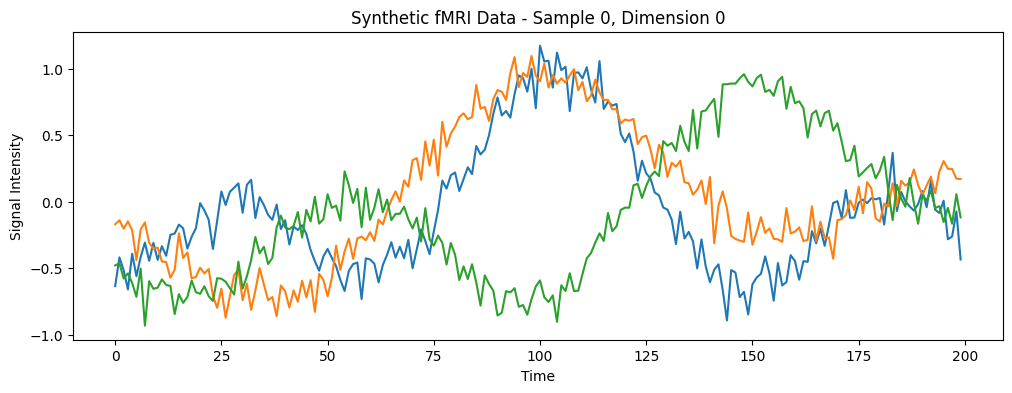

In [3]:
# Parameters
batch_size = 1000
seq_len = 200
d_in = 100

# Generate data
data = generate_synthetic_fmri_data(batch_size, seq_len, d_in)
print("Data shape", data.shape)
# Plot the first sample and dimension
plt.figure(figsize=(12, 4))
plt.plot(data[0, :, 0].numpy())
plt.plot(data[0, :, 1].numpy())
plt.plot(data[0, :, 2].numpy())

plt.title('Synthetic fMRI Data - Sample 0, Dimension 0')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.show()


In [4]:
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)  # Shape: (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(1)  # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        x: Tensor of shape (sequence_length, batch_size, d_model)
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class MaskedAutoencoder(nn.Module):
    def __init__(self, patch_size, d_in=d_in,d_model=64, nhead=4, num_encoder_layers=4, num_decoder_layers=2, dim_feedforward=128, dropout=0.1):
        super(MaskedAutoencoder, self).__init__()
        self.patch_size = patch_size
        self.d_model = d_model  # Embedding dimension
        self.d_in = d_in
        
        # Shared Conv1d layer to project patches into embeddings
        # We treat the time dimension within each patch as the input sequence
        self.encoder_projection = nn.Conv1d(in_channels=d_in, out_channels=d_model, kernel_size=patch_size)
        
        # Positional Encoding for the transformer
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Transformer Decoder (can be a shallow transformer)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # Projection back to time series
        # self.decoder_projection = nn.Linear(d_model, self.patch_size * self.d_in)
        self.decoder_projection = nn.ConvTranspose1d(
            in_channels=d_model,
            out_channels=d_in,
            kernel_size=patch_size,
            stride=patch_size
        )
    def patchify(self, x):
        """
        Splits the input tensor into patches.
        Input: x of shape (batch_size, seq_len, d_in)
        Returns: x_patches of shape (batch_size, n_patches, patch_size, d_in)
        """
        batch_size, seq_len, d_in = x.shape
        ps = self.patch_size
        n_patches = seq_len // ps  # Number of full patches
        x = x[:, :n_patches * ps, :]  # Trim to fit full patches
        x_patches = x.view(batch_size, n_patches, ps, d_in)
        return x_patches
    
    def depatchify(self, x_patches):
        """
        Reconstructs the original tensor from the patched tensor.
        Input: x_patches of shape (batch_size, n_patches, patch_size, d_in)
        Returns: x_reconstructed of shape (batch_size, seq_len, d_in)
        """
        batch_size, n_patches, ps, d_in = x_patches.shape
        x_reconstructed = x_patches.view(batch_size, n_patches * ps, d_in)
        return x_reconstructed
    
    def mask_patches(self, x_patches, mask_ratio=0.5):
        """
        Masks some patches in the input tensor.
        Different dimensions can be masked in different positions.
        Input: x_patches of shape (batch_size, n_patches, patch_size, d_in)
        Returns: x_masked, mask
        """
        batch_size, n_patches, ps, d_in = x_patches.shape
        num_masked_patches = round(mask_ratio * n_patches)
        
        # Generate random masks
        random_scores = torch.rand(batch_size, n_patches, d_in)
        # Determine threshold for masking
        threshold = torch.kthvalue(random_scores, num_masked_patches, dim=1).values.unsqueeze(1)
        mask = (random_scores < threshold).float().to(x_patches.device)
        
        # Apply mask
        mask_expanded = mask.unsqueeze(2)  # Shape: (batch_size, n_patches, 1, d_in)
        x_masked = x_patches.clone()
        x_masked = x_masked * (1 - mask_expanded)
        
        return x_masked, mask
    
    def forward(self, x, mask_ratio=0.5):
        # Patchify
        x_patches = self.patchify(x)  # Shape: (batch_size, n_patches, patch_size, d_in)
        print(f'Patchified input shape: {x_patches.shape}')
        
        # Mask patches
        x_masked_patches, mask = self.mask_patches(x_patches, mask_ratio=mask_ratio)
        print(f'Masked patches shape: {x_masked_patches.shape}')
        print(f'Mask shape: {mask.shape}')
        
        batch_size, n_patches, ps, d_in = x_masked_patches.shape
        
        # Reshape for Conv1d
        x_patches_reshaped = x_masked_patches.view(batch_size * n_patches, ps, d_in)  # Shape: (batch_size * n_patches, patch_size, d_in)
        x_patches_reshaped = x_patches_reshaped.permute(0, 2, 1)  # Shape: (batch_size * n_patches, d_in, patch_size)
        
        # Apply Conv1d to project patches into embeddings
        embeddings = self.encoder_projection(x_patches_reshaped)  # Shape: (batch_size * n_patches, d_model, output_length)
        embeddings = embeddings.squeeze(-1)  # Remove the last dimension if kernel_size == patch_size, output_length == 1
        print(f'Embeddings shape: {embeddings.shape}')
        
        # Reshape embeddings for the transformer
        embeddings = embeddings.view(batch_size, n_patches, self.d_model)  # Shape: (batch_size, n_patches, d_model)
        embeddings = embeddings.permute(1, 0, 2)  # Shape: (n_patches, batch_size, d_model)
        print(f'Embeddings after permute shape: {embeddings.shape}')
        
        # Add positional encoding
        embeddings = self.positional_encoding(embeddings)
        print(f'Embeddings after positional encoding shape: {embeddings.shape}')
        
        # Transformer Encoder
        z = self.transformer_encoder(embeddings)  # Shape: (n_patches, batch_size, d_model)
        print(f'Encoder output (z) shape: {z.shape}')
        
        # Transformer Decoder
        decoded = self.transformer_decoder(z, z)  # Shape: (n_patches, batch_size, d_model)
        print(f'Decoder output shape: {decoded.shape}')
        
        # Prepare for ConvTranspose1d
        decoded = decoded.permute(1, 0, 2)  # Shape: (batch_size, n_patches, d_model)
        decoded = decoded.view(batch_size * n_patches, self.d_model, 1)  # Shape: (batch_size * n_patches, d_model, 1)
        print(f'Decoded embeddings reshaped for ConvTranspose1d: {decoded.shape}')
        
        # Apply ConvTranspose1d to reconstruct patches
        reconstructed_patches = self.decoder_projection(decoded)  # Shape: (batch_size * n_patches, d_in, patch_size)
        print(f'Reconstructed patches shape: {reconstructed_patches.shape}')
        
        # Reshape to original format
        reconstructed_patches = reconstructed_patches.view(batch_size, n_patches, d_in, self.patch_size)
        reconstructed_patches = reconstructed_patches.permute(0, 1, 3, 2)  # Shape: (batch_size, n_patches, patch_size, d_in)
        
        # Depatchify
        x_reconstructed = self.depatchify(reconstructed_patches)
        print(f'Reconstructed output shape: {x_reconstructed.shape}')
        
        return x_reconstructed, mask

## Can the model divide signal into patches and reconstruct it correclty?

In [5]:
round(9.6)

10

In [6]:
patch_size = 20  # Example patch size
model = MaskedAutoencoder(patch_size=patch_size)


/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
x_patches = model.patchify(data)
print(f'x_patches shape: {x_patches.shape}')


x_patches shape: torch.Size([1000, 10, 20, 100])


In [8]:
x_reconstructed = model.depatchify(x_patches)


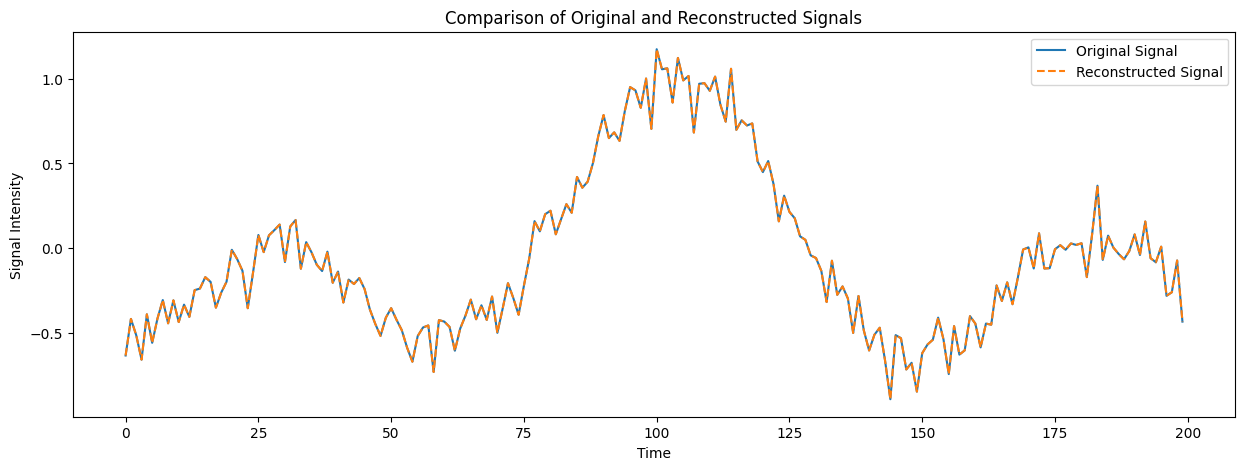

In [10]:
# Select a sample and dimension
sample_idx = 0
dim_idx = 0

# Original signal (trimmed)
original_signal = data[sample_idx, :, dim_idx]

# Reconstructed signal
reconstructed_signal = x_reconstructed[sample_idx, :, dim_idx]

# Plot both signals
plt.figure(figsize=(15, 5))
plt.plot(original_signal.numpy(), label='Original Signal')
plt.plot(reconstructed_signal.numpy(), linestyle='--', label='Reconstructed Signal')
plt.title('Comparison of Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.legend()
plt.show()


In [11]:
# Calculate effective sequence length
n_patches = x_patches.shape[1]
effective_seq_len = n_patches * patch_size

# Trim the original data
data_trimmed = data[:, :effective_seq_len, :]

# Check if reconstructed data matches the trimmed original data
is_close = torch.allclose(x_reconstructed, data_trimmed, atol=1e-6)
print(f'Does reconstructed data match original data? {is_close}')


Does reconstructed data match original data? True


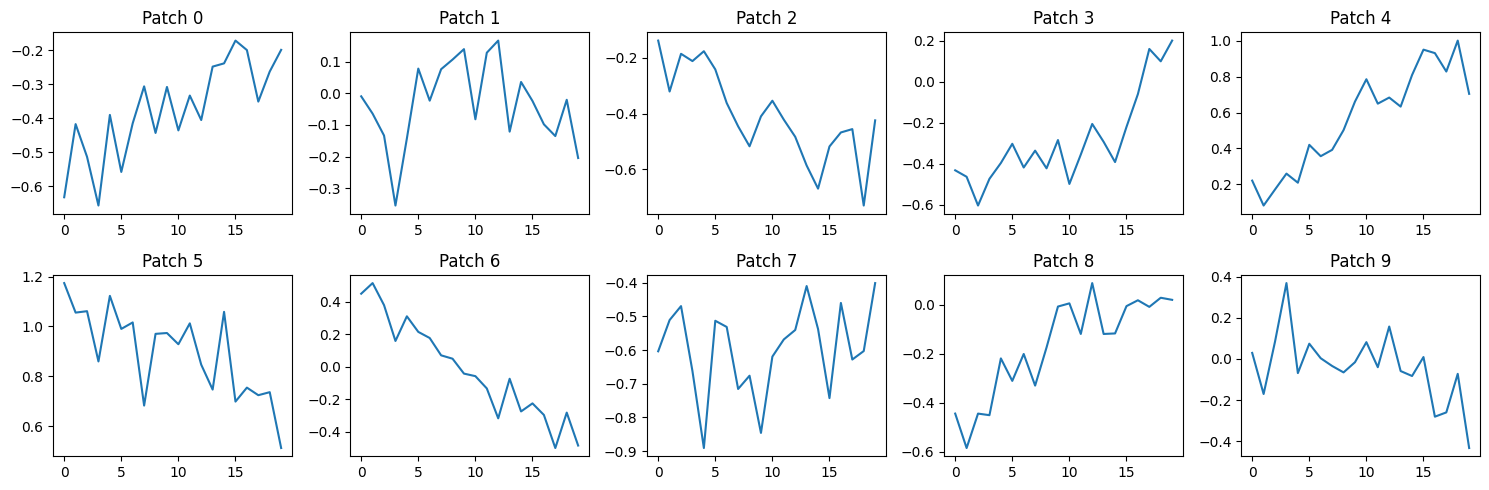

In [12]:
sample_idx = 0
dim_idx = 0

# Extract patches
patches = x_patches[sample_idx, :, :, dim_idx]  # Shape: (n_patches, patch_size)

# Plot the first few patches
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i, ax in enumerate(axes.flatten()):
    if i < patches.shape[0]:
        ax.plot(patches[i].numpy())
        ax.set_title(f'Patch {i}')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()


## Is the masking of the model correct?

In [13]:
x_masked, mask = model.mask_patches(x_patches, mask_ratio=1.)
print(f'x_masked shape: {x_masked.shape}')
print(f'mask shape: {mask.shape}')


x_masked shape: torch.Size([1000, 10, 20, 100])
mask shape: torch.Size([1000, 10, 100])


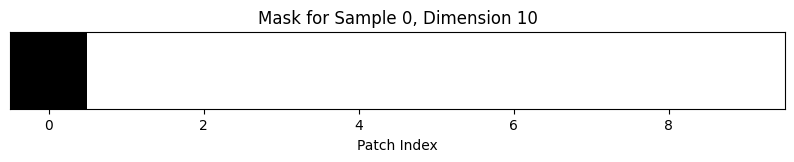

In [14]:
sample_idx = 0
dim_idx = 10

mask_sample = mask[sample_idx, :, dim_idx]  # Shape: (n_patches,)
plt.figure(figsize=(10, 1))
plt.imshow(mask_sample.unsqueeze(0), cmap='gray', aspect='auto')
plt.title(f'Mask for Sample {sample_idx}, Dimension {dim_idx}')
plt.xlabel('Patch Index')
plt.yticks([])
plt.show()


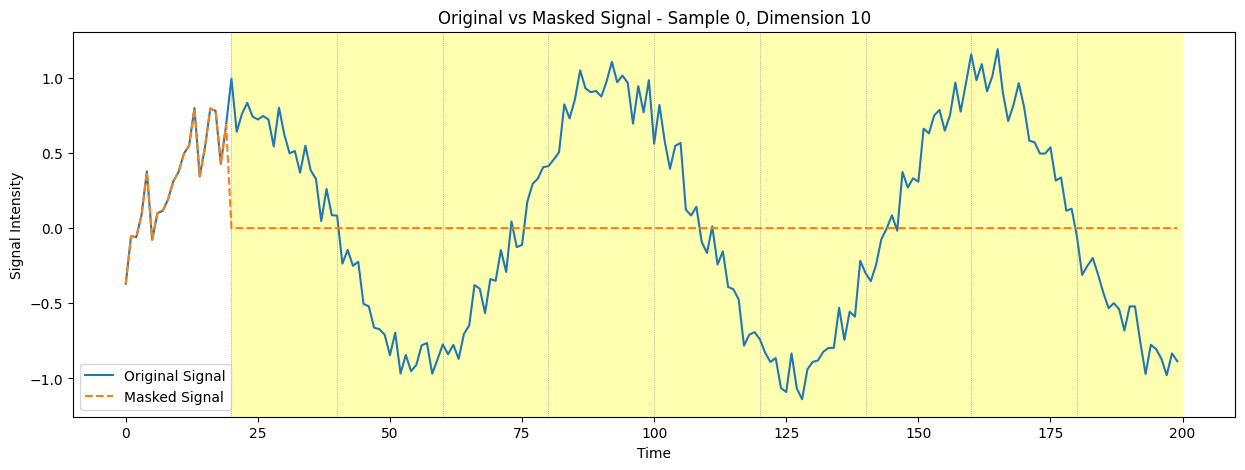

In [15]:
# Reconstruct original signal
original_patches = x_patches[sample_idx, :, :, dim_idx]  # Shape: (n_patches, patch_size)
original_signal = original_patches.reshape(-1)

# Reconstruct masked signal
masked_patches = x_masked[sample_idx, :, :, dim_idx]
masked_signal = masked_patches.reshape(-1)

# Get mask for the sample and dimension
mask_sample = mask[sample_idx, :, dim_idx]  # Shape: (n_patches,)

# Plot the signals
plt.figure(figsize=(15, 5))
plt.plot(original_signal.numpy(), label='Original Signal')
plt.plot(masked_signal.numpy(), label='Masked Signal', linestyle='--')

# Add vertical dotted lines at patch boundaries
for i in range(1, n_patches):
    plt.axvline(x=i * patch_size, color='gray', linestyle=':', linewidth=0.5)

# Apply background color to masked patches
for i, m in enumerate(mask_sample):
    if m.item() == 1.0:
        start = i * patch_size
        end = (i + 1) * patch_size
        plt.axvspan(start, end, facecolor='yellow', alpha=0.3)

plt.title(f'Original vs Masked Signal - Sample {sample_idx}, Dimension {dim_idx}')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.legend()
plt.show()


## Can we train a model?

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)  # Shape: (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(1)  # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        x: Tensor of shape (sequence_length, batch_size, d_model)
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class MaskedAutoencoder(nn.Module):
    def __init__(self, patch_size, d_in, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(MaskedAutoencoder, self).__init__()
        self.patch_size = patch_size
        self.d_model = d_model  # Embedding dimension
        self.d_in = d_in
        
        # Shared Conv1d layer to project patches into embeddings
        self.encoder_projection = nn.Conv1d(in_channels=d_in, out_channels=d_model, kernel_size=patch_size)
        
        # Positional Encoding for the transformer
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # Projection back to time series using ConvTranspose1d
        self.decoder_projection = nn.ConvTranspose1d(
            in_channels=d_model,
            out_channels=d_in,
            kernel_size=patch_size
        )
        
    def patchify(self, x):
        batch_size, seq_len, d_in = x.shape
        ps = self.patch_size
        n_patches = seq_len // ps  # Number of full patches
        x = x[:, :n_patches * ps, :]  # Trim to fit full patches
        x_patches = x.view(batch_size, n_patches, ps, d_in)
        return x_patches
    
    def depatchify(self, x_patches):
        batch_size, n_patches, ps, d_in = x_patches.shape
        x_reconstructed = x_patches.view(batch_size, n_patches * ps, d_in)
        return x_reconstructed
    
    def mask_patches(self, x_patches, mask_ratio=0.5):
        batch_size, n_patches, ps, d_in = x_patches.shape
        num_masked_patches = int(mask_ratio * n_patches)
        
        # Generate random masks
        random_scores = torch.rand(batch_size, n_patches, d_in, device=x_patches.device)
        # Determine threshold for masking
        threshold = torch.kthvalue(random_scores, num_masked_patches, dim=1).values.unsqueeze(1)
        mask = (random_scores < threshold).float()
        
        # Apply mask
        mask_expanded = mask.unsqueeze(2)  # Shape: (batch_size, n_patches, 1, d_in)
        x_masked = x_patches.clone()
        x_masked = x_masked * (1 - mask_expanded)
        
        return x_masked, mask
    
    def forward(self, x, mask_ratio=0.5):
        # Patchify
        x_patches = self.patchify(x)  # Shape: (batch_size, n_patches, patch_size, d_in)
        # print(f'Patchified input shape: {x_patches.shape}')
        
        # Mask patches
        x_masked_patches, mask = self.mask_patches(x_patches, mask_ratio=mask_ratio)
        # print(f'Masked patches shape: {x_masked_patches.shape}')
        # print(f'Mask shape: {mask.shape}')
        
        batch_size, n_patches, ps, d_in = x_masked_patches.shape
        
        # Reshape for Conv1d
        x_patches_reshaped = x_masked_patches.view(batch_size * n_patches, ps, d_in)  # Shape: (batch_size * n_patches, patch_size, d_in)
        x_patches_reshaped = x_patches_reshaped.permute(0, 2, 1)  # Shape: (batch_size * n_patches, d_in, patch_size)
        
        # Apply Conv1d to project patches into embeddings
        embeddings = self.encoder_projection(x_patches_reshaped)  # Shape: (batch_size * n_patches, d_model, output_length)
        embeddings = embeddings.squeeze(-1)  # Remove the last dimension if kernel_size == patch_size, output_length == 1
        # print(f'Embeddings shape: {embeddings.shape}')
        
        # Reshape embeddings for the transformer
        embeddings = embeddings.view(batch_size, n_patches, self.d_model)  # Shape: (batch_size, n_patches, d_model)
        embeddings = embeddings.permute(1, 0, 2)  # Shape: (n_patches, batch_size, d_model)
        # print(f'Embeddings after permute shape: {embeddings.shape}')
        
        # Add positional encoding
        embeddings = self.positional_encoding(embeddings)
        # print(f'Embeddings after positional encoding shape: {embeddings.shape}')
        
        # Transformer Encoder
        z = self.transformer_encoder(embeddings)  # Shape: (n_patches, batch_size, d_model)
        # print(f'Encoder output (z) shape: {z.shape}')
        
        # Transformer Decoder
        decoded = self.transformer_decoder(z, z)  # Shape: (n_patches, batch_size, d_model)
        # print(f'Decoder output shape: {decoded.shape}')
        
        # Prepare for ConvTranspose1d
        decoded = decoded.permute(1, 0, 2).contiguous()  # Shape: (batch_size, n_patches, d_model)
        decoded = decoded.view(batch_size * n_patches, self.d_model).unsqueeze(-1)  # Shape: (batch_size * n_patches, d_model, 1)
        # print(f'Decoded embeddings reshaped for ConvTranspose1d: {decoded.shape}')
        
        # Apply ConvTranspose1d to reconstruct patches
        reconstructed_patches = self.decoder_projection(decoded)  # Shape: (batch_size * n_patches, d_in, patch_size)
        # print(f'Reconstructed patches shape: {reconstructed_patches.shape}')
        
        reconstructed_patches = reconstructed_patches.contiguous()
        
        # Reshape to original format
        reconstructed_patches = reconstructed_patches.view(batch_size, n_patches, d_in, self.patch_size)
        reconstructed_patches = reconstructed_patches.permute(0, 1, 3, 2).contiguous()  # Shape: (batch_size, n_patches, patch_size, d_in)
        
        # Depatchify
        x_reconstructed = self.depatchify(reconstructed_patches)
        # print(f'Reconstructed output shape: {x_reconstructed.shape}')
        
        return x_reconstructed, mask


In [17]:
import torch

def count_model_parameters(model):
    # Sum the number of parameters in all layers
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,} M")


In [18]:
# Model hyperparameters
patch_size = 20
d_model = 256  # Embedding dimension
nhead = 4
num_encoder_layers = 6
num_decoder_layers = 4
dim_feedforward = 512
dropout = 0.1

In [19]:
torch.cuda.empty_cache()

In [32]:
device = "cuda:2"

model = MaskedAutoencoder(
    patch_size=patch_size,
    d_in = d_in,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout
)

model.to(device)
data = data.to(device)

count_model_parameters(model)

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Total number of parameters: 7,350,116 M


In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [50]:
model.train()
print("data shape", data.shape)
output, mask = model(data, mask_ratio=0.5)
print(f'Output shape: {output.shape}')
print(f'Mask shape: {mask.shape}')


# Since the output might be shorter due to trimming during patchify
effective_seq_len = output.shape[1]
data_trimmed = data[:, :effective_seq_len, :]

loss = criterion(output, data_trimmed)
print(f'Loss: {loss.item()}')


data shape torch.Size([1000, 200, 100])
Output shape: torch.Size([1000, 200, 100])
Mask shape: torch.Size([1000, 10, 100])
Loss: 0.14276008307933807


In [51]:
patch_size

20

### Training loop

In [52]:
num_epochs = 3000
mask_ratio = 0.2


In [53]:
# model.encoder_projection.device

In [54]:
pbar = tqdm.trange(num_epochs)
loss_history = []

masked_loss = False
for epoch in pbar:
    
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output, mask = model(data, mask_ratio=0.1)
    
    # Compute loss
    effective_seq_len = output.shape[1]
    data_trimmed = data[:, :effective_seq_len, :]
    # 
    
    if masked_loss:
    # Compute loss only over masked patches
        mask_expanded = mask.unsqueeze(2).repeat(1, 1, patch_size, 1)  # Shape: (batch_size, n_patches, patch_size, d_in)
        mask_flat = mask_expanded.view(batch_size, -1, d_in)

        # Trim data and output
        data_masked = data_trimmed * mask_flat
        output_masked = output * mask_flat

        loss = criterion(output_masked, data_masked)
    else:
        loss = criterion(output, data_trimmed)
        
    loss_history.append(loss.item())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [3000/3000], Loss: 0.0208: 100%|███████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:46<00:00, 13.22it/s]


In [55]:
mask_ratio

0.2

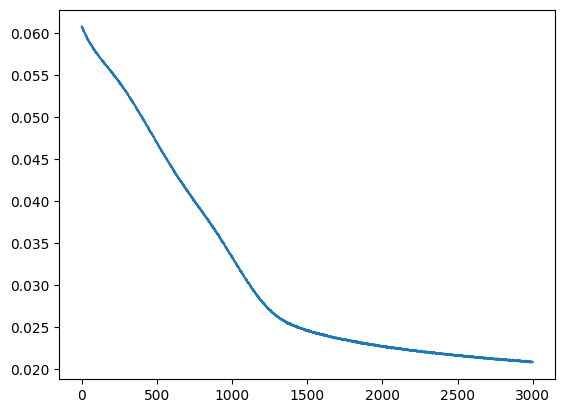

In [56]:
plt.plot(loss_history)

## visualize reconstructions

In [57]:
model.eval()
with torch.no_grad():
    reconstructed, _ = model(data, mask_ratio=mask_ratio)
    reconstructed = reconstructed.cpu()


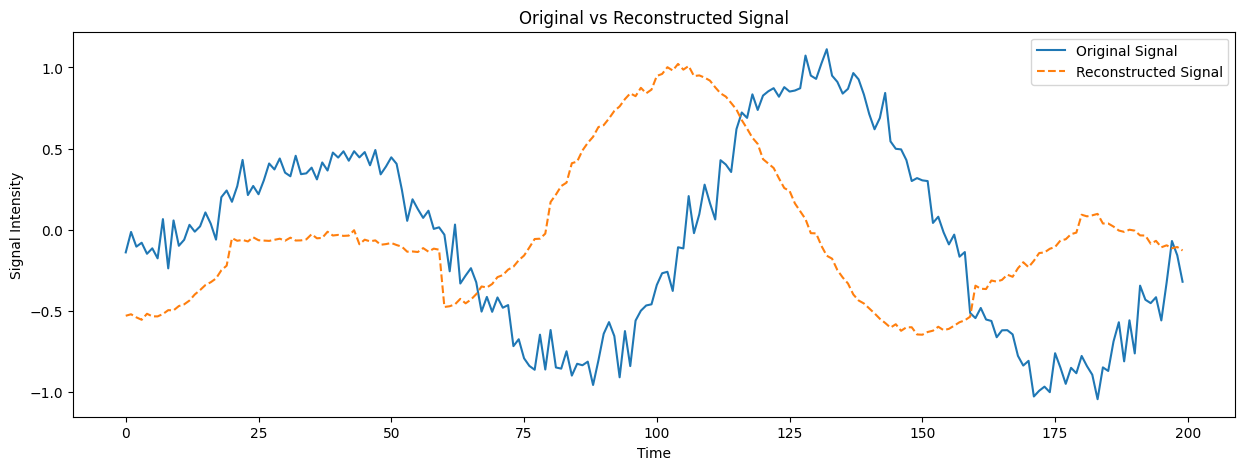

In [71]:
# Select a sample and dimension
sample_idx = 0
dim_idx = 35

# Original signal (trimmed)
original_signal = data_trimmed[sample_idx, :, dim_idx].cpu()

# Reconstructed signal
reconstructed_signal = reconstructed[sample_idx, :, 0]

# Plot both signals
plt.figure(figsize=(15, 5))
plt.plot(original_signal.numpy(), label='Original Signal')
plt.plot(reconstructed_signal.numpy(), linestyle='--', label='Reconstructed Signal')
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.legend()
plt.show()
# 